In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import requests

# Load and analyze bare benchmark results

ASV web display is rich but does not do everythin. When you need to run some analysis it does not provide, you can load the raw benchmark data, which are stored in the `results` folder of the `gh-pages` branch of the repository.

Consider an example: let's check how the matrix-multiply routine `gemm` scales with the array size and compare to the expected cubic scaling, $\sim N^3$.

First note that the results are stored as json files in the `results/machine-name/` directory. We load the json for some commit hash:

In [2]:
url = "https://raw.githubusercontent.com/OpenMathLib/BLAS-Benchmarks/gh-pages/results/gha-aws-graviton/fb8ab261-virtualenv-py3.12.json"
results = requests.get(url).json()

The format of the results file is documented in the [ASV developer docs](https://asv.readthedocs.io/en/stable/dev.html#benchmark-suite-layout-and-file-formats).

In short, we are looking for a key `"results"` and a subkey with the benchmark name:

In [5]:
gemm_results = results["results"]["benchmarks.gemm.time_gemm"]

Now, `gemm_results` is a list of lists and we are interested in the two first elements, which hold the benchmark results (in seconds, for `time_` benchmarks) and parameter lists. 

In [18]:
import itertools

# json format is documented 
# https://asv.readthedocs.io/en/stable/dev.html#benchmark-suite-layout-and-file-formats
# In short, for multiple parameters the `results` list corresponds to an outer product of
# parameters.
#
param_combs = itertools.product(*gemm_results[1])
for res, parm in zip(gemm_results[0], param_combs):
    print(parm, res)

('100', "'s'") 3.094066903409531e-05
('100', "'d'") 5.297513349516733e-05
('100', "'c'") 0.0001136026793479741
('100', "'z'") 0.00020522390999985873
('200', "'s'") 0.000190337368421143
('200', "'d'") 0.0003644822413794349
('200', "'c'") 0.0007786495769218722
('200', "'z'") 0.0015165394285706463
('400', "'s'") 0.0013642758749998762
('400', "'d'") 0.002745753000002793
('400', "'c'") 0.0060967010000041455
('400', "'z'") 0.012055932499990263
('600', "'s'") 0.0046867961666663405
('600', "'d'") 0.009184491749998358
('600', "'c'") 0.02009252350001134
('600', "'z'") 0.040977206500002694
('800', "'s'") 0.01060090300001093
('800', "'d'") 0.021474112999996464
('800', "'c'") 0.0471736915000065
('800', "'z'") 0.09596087750000493
('1000', "'s'") 0.02110663850000094
('1000', "'d'") 0.04267209399999672
('1000', "'c'") 0.09408231599999795
('1000', "'z'") 0.18838757800000394


Let's now quickly read in the double-precision, `'d'`, results vs the matrix size, run a linear regression in the logspace (since we expect a power-law scaling), and plot everything:

In [63]:
sizes, times = [], []

param_combs = itertools.product(*gemm_results[1])
for res, parm in zip(gemm_results[0], param_combs):
    size, var = parm
    if var == "'s'":
        sizes.append(int(size))
        times.append(res)

times = np.asarray(times)
sizes = np.asarray(sizes)

In [65]:
log_sizes = np.log(sizes)
log_times = np.log(times)

regr = linregress(log_sizes, log_times)
regr

LinregressResult(slope=2.843086680878505, intercept=-23.556217088225388, rvalue=0.9996655473355168, pvalue=1.6776917146898127e-07, stderr=0.036774890861551744, intercept_stderr=0.22192218793752486)

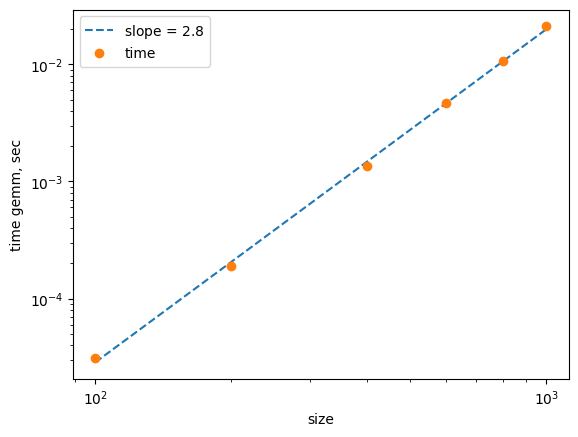

In [67]:
plt.loglog(sizes, np.exp(regr.intercept) * sizes**regr.slope, '--', label=r"slope = $%.3s$" % regr.slope)
plt.loglog(sizes, times, 'o', label='time')

plt.xlabel('size')
plt.ylabel('time gemm, sec')
plt.legend()

So indeed, the time complexity is about $O(N^{2.8})$, which reasonably close to the ideal result of $O(N^3)$.